In [1]:
import sys
sys.path.append('..')

import uproot

import numpy as np
import pandas as pd
import awkward as ak
import matplotlib.pyplot as plt
import seaborn as sns

from skimage.measure import label, regionprops
from scipy.ndimage import label as scipy_label
from collections import deque

from lariat import Event

In [2]:
FINAL = '/Users/user/data/research/proton-deuteron/csv/final.pkl' # clean protons + deuterons

In [3]:
df = pd.read_pickle(FINAL)

In [4]:
df.columns

Index(['event_idx', 'run', 'subrun', 'event', 'file_path', 'event_index',
       'particle_type', 'plane', 'cluster_idx', 'area', 'max_intensity',
       'min_intensity', 'mean_intensity', 'total_intensity', 'centroid_x',
       'centroid_y', 'bbox_min_row', 'bbox_min_col', 'bbox_max_row',
       'bbox_max_col', 'width', 'height', 'aspect_ratio', 'compactness',
       'image_intensity', 'matrix_transformed', 'column_maxes', 'normalised',
       'adcdiff', 'maxdiff', 'beamline_mass', 'energy', 'rr'],
      dtype='object')

In [5]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from joblib import Parallel, delayed

In [6]:
cols = ['run', 'subrun', 'event', 'energy', 'rr', 'beamline_mass']
df_small = df[cols]
dfs = [row.to_frame().T for _, row in df_small.iterrows()]

In [7]:
def normalize_rr(row):
    rr = np.asarray(row['rr'])
    rr_min = rr.min()
    rr_max = rr.max()
    if rr_max > rr_min:
        return (rr - rr_min) / (rr_max - rr_min)
    else:
        return np.zeros_like(rr)

df['rr_norm'] = df.apply(normalize_rr, axis=1)

In [8]:
# Add a column to df with the max value from each 'energy' array
df['energy_max'] = df['energy'].apply(lambda arr: np.max(arr) if isinstance(arr, (np.ndarray, list)) and len(arr) > 0 else np.nan)
df['energy_max'].head()

0    20719.0
1     5736.0
2    16285.0
3     5922.0
4     5006.0
Name: energy_max, dtype: float64

/Users/user/code/research/proton-deuteron/.venv/lib/python3.11/site-packages/scipy/_lib/_util.py:1272: RuntimeWarning: divide by zero encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/Users/user/code/research/proton-deuteron/.venv/lib/python3.11/site-packages/scipy/_lib/_util.py:1272: RuntimeWarning: overflow encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/Users/user/code/research/proton-deuteron/.venv/lib/python3.11/site-packages/scipy/_lib/_util.py:1272: RuntimeWarning: invalid value encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/Users/user/code/research/proton-deuteron/.venv/lib/python3.11/site-packages/scipy/_lib/_util.py:1272: RuntimeWarning: divide by zero encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/Users/user/code/research/proton-deuteron/.venv/lib/python3.11/site-packages/scipy/_lib/_util.py:1272: RuntimeWarning: overflow encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/Users/user/code/research/proton-deuteron/.

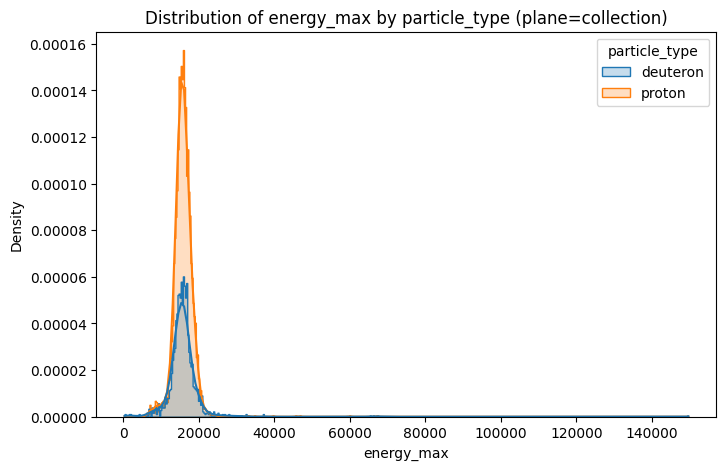

/Users/user/code/research/proton-deuteron/.venv/lib/python3.11/site-packages/scipy/_lib/_util.py:1272: RuntimeWarning: divide by zero encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/Users/user/code/research/proton-deuteron/.venv/lib/python3.11/site-packages/scipy/_lib/_util.py:1272: RuntimeWarning: overflow encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/Users/user/code/research/proton-deuteron/.venv/lib/python3.11/site-packages/scipy/_lib/_util.py:1272: RuntimeWarning: invalid value encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/Users/user/code/research/proton-deuteron/.venv/lib/python3.11/site-packages/scipy/_lib/_util.py:1272: RuntimeWarning: divide by zero encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/Users/user/code/research/proton-deuteron/.venv/lib/python3.11/site-packages/scipy/_lib/_util.py:1272: RuntimeWarning: overflow encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/Users/user/code/research/proton-deuteron/.

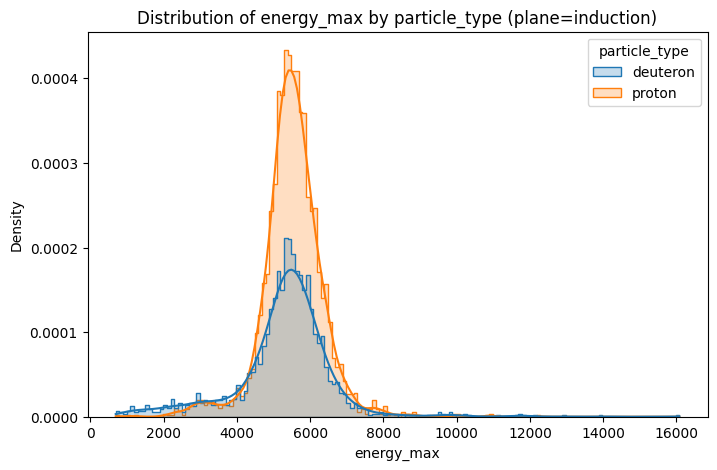

In [9]:
if 'particle_type' in df.columns and 'plane' in df.columns:
    for plane_val in df['plane'].unique():
        plt.figure(figsize=(8, 5))
        subset = df[df['plane'] == plane_val]
        sns.histplot(data=subset, x='energy_max', hue='particle_type', bins='auto', kde=True, element='step', stat='density')
        plt.title(f"Distribution of energy_max by particle_type (plane={plane_val})")
        plt.xlabel('energy_max')
        plt.ylabel('Density')
        plt.show()
else:
    print("Column 'particle_type' or 'plane' not found in df.")

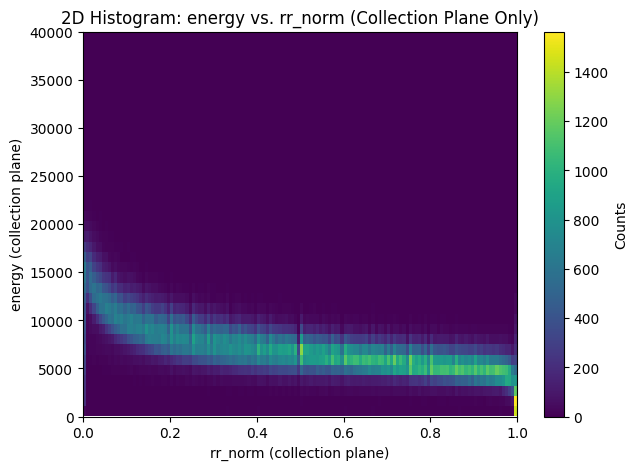

In [10]:
# 2D histogram of energy vs. rr_norm for collection plane only
collection_plane = 'collection'  # Change if your collection plane uses a different value
df_coll = df[df['plane'] == collection_plane]
plt.figure(figsize=(7, 5))
plt.hist2d(np.concatenate(df_coll['rr_norm'].values), np.concatenate(df_coll['energy'].values), bins=140, cmap='viridis')
plt.xlabel('rr_norm (collection plane)')
plt.ylabel('energy (collection plane)')
plt.title('2D Histogram: energy vs. rr_norm (Collection Plane Only)')
plt.colorbar(label='Counts')
plt.ylim(0, 40000)
plt.show()

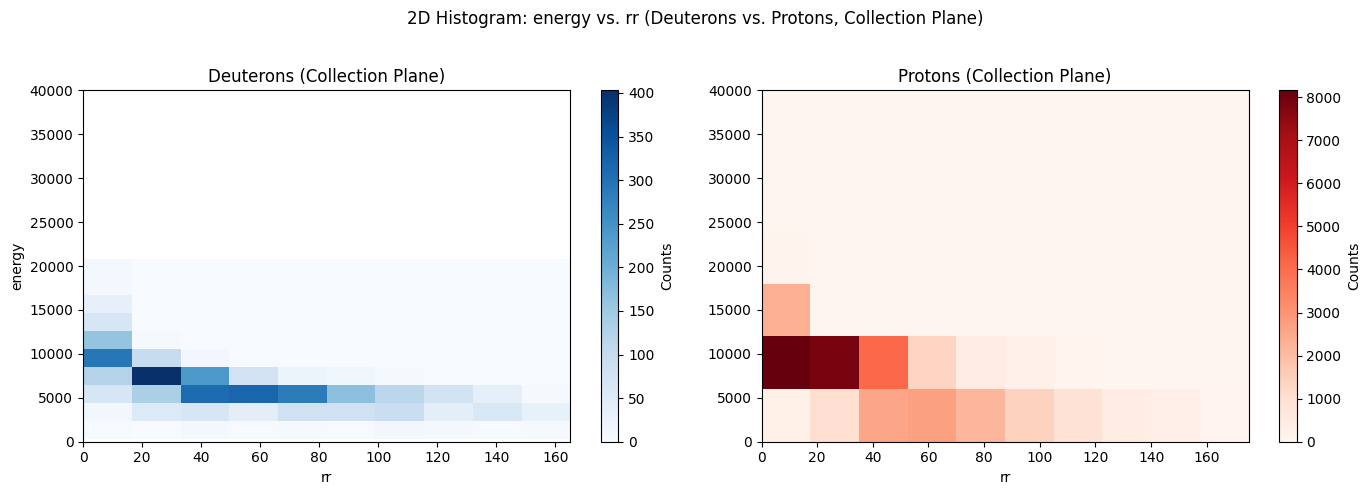

In [110]:
# 2D histograms for collection plane: deuterons vs. protons
collection_plane = 'collection'  # Change if your collection plane uses a different value
df_coll = df[df['plane'] == collection_plane]

deuteron_mass = 1875.6  # MeV/c^2
proton_mass = 938.3     # MeV/c^2
mass_tol = 10           # MeV/c^2

df_deut = df_coll[(np.abs(df_coll['beamline_mass'] - deuteron_mass) < mass_tol)]
df_prot = df_coll[np.abs(df_coll['beamline_mass'] - proton_mass) < mass_tol]

# df_deut = df_coll[(df_coll['particle_type'] == 'deuteron') & (df_coll['height'] < 20)]
# df_prot = df_coll[(df_coll['particle_type'] == 'proton') & (df_coll['height'] < 20)]


fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=False)

h1 = axes[0].hist2d(np.concatenate(df_deut['rr'].values), np.concatenate(df_deut['energy'].values), bins=10, cmap='Blues')
axes[0].set_title('Deuterons (Collection Plane)')
axes[0].set_xlabel('rr')
axes[0].set_ylabel('energy')
axes[0].set_ylim(0, 40000)
fig.colorbar(h1[3], ax=axes[0], label='Counts')

h2 = axes[1].hist2d(np.concatenate(df_prot['rr'].values), np.concatenate(df_prot['energy'].values), bins=10, cmap='Reds')
axes[1].set_title('Protons (Collection Plane)')
axes[1].set_xlabel('rr')
axes[1].set_ylim(0, 40000)
fig.colorbar(h2[3], ax=axes[1], label='Counts')

plt.suptitle('2D Histogram: energy vs. rr (Deuterons vs. Protons, Collection Plane)')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [111]:
df_prot = df_prot.sample(n=df_deut.shape[0]); df_deut.shape

(46, 36)

In [112]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel
import numpy as np

# Combine all 'rr' and 'energy' arrays for df_deut
rr_deut = np.concatenate(df_deut['rr'].values).reshape(-1, 1)  # Reshape for GP input
energy_deut = np.concatenate(df_deut['energy'].values)

# Combine all 'rr' and 'energy' arrays for df_prot
rr_prot = np.concatenate(df_prot['rr'].values).reshape(-1, 1)  # Reshape for GP input
energy_prot = np.concatenate(df_prot['energy'].values)

In [130]:
import torch
import gpytorch

device = device = torch.device("cpu")

class GPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()

        rbf = gpytorch.kernels.RBFKernel(
            lengthscale_constraint=gpytorch.constraints.Interval(1.0, 1e2)
        )
        
        rbf.lengthscale = 50.0

        scaled_rbf = gpytorch.kernels.ScaleKernel(rbf, outputscale_constraint=gpytorch.constraints.Interval(1e-3, 1e3))

        self.covar_module = scaled_rbf 

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

def train_gp(X, Y, label):
    X = torch.tensor(X, dtype=torch.float32).to(device)
    Y = torch.tensor(Y, dtype=torch.float32).to(device)

    likelihood = gpytorch.likelihoods.GaussianLikelihood(
        noise_constraint=gpytorch.constraints.Interval(1e-2, 1e1)
    )
    likelihood.noise = 1.0
    
    model = GPModel(X, Y, likelihood).to(device)

    model.train()
    likelihood.train()

    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for i in range(200):
        optimizer.zero_grad()
        output = model(X)
        loss = -mll(output, Y)
        loss.backward()
        optimizer.step()

    print(f"Trained GP for {label}")
    return model, likelihood

# Train GP for deuterons
model_deut, likelihood_deut = train_gp(rr_deut, energy_deut, "deuterons")

# Train GP for protons
model_prot, likelihood_prot = train_gp(rr_prot, energy_prot, "protons")

Trained GP for deuterons
Trained GP for protons


In [131]:
def plot_gp(model, likelihood, X_train, Y_train, label):
    model.eval()
    likelihood.eval()

    x_min = X_train.min().item()
    x_max = X_train.max().item()

    # Test inputs
    X_test = torch.linspace(
        x_min - 0.1 * abs(x_min),
        x_max + 0.1 * abs(x_max),
        500
    ).unsqueeze(1).to(X_train.device)

    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        preds = likelihood(model(X_test))
        mean = preds.mean.cpu().numpy()
        lower, upper = preds.confidence_region()
        lower = lower.cpu().numpy()
        upper = upper.cpu().numpy()

    # Convert training data to NumPy
    X_train_np = X_train.cpu().numpy()
    Y_train_np = Y_train.cpu().numpy()
    X_test_np = X_test.cpu().numpy()

    # Plot
    plt.figure(figsize=(8, 5))
    plt.plot(X_test_np, mean, label="GP mean")
    plt.fill_between(X_test_np.squeeze(), lower, upper, alpha=0.3, label="95% CI")
    plt.scatter(X_train_np, Y_train_np, color="black", s=5, label="Training data")
    plt.title(f"GP fit: {label}")
    plt.xlabel("Input")
    plt.ylabel("Output")
    plt.legend()
    plt.grid(True)
    plt.show()

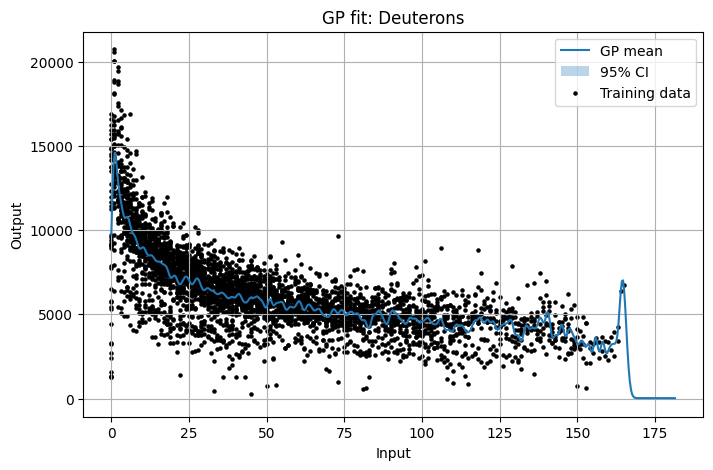

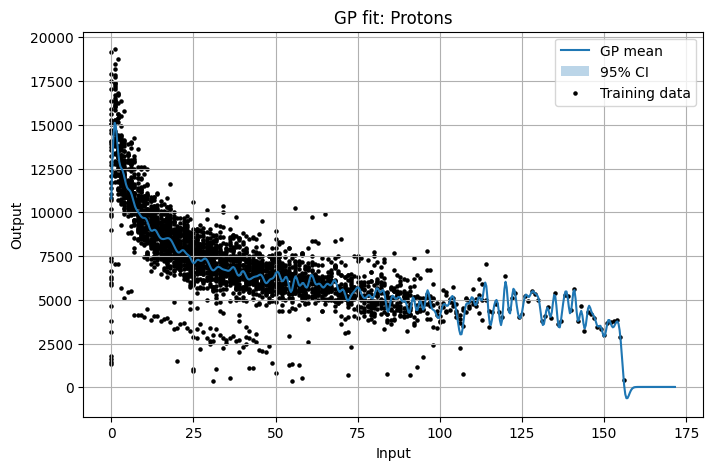

In [132]:
plot_gp(model_deut, likelihood_deut,
        torch.tensor(rr_deut, dtype=torch.float32),
        torch.tensor(energy_deut, dtype=torch.float32),
        label="Deuterons")

plot_gp(model_prot, likelihood_prot,
        torch.tensor(rr_prot, dtype=torch.float32),
        torch.tensor(energy_prot, dtype=torch.float32),
        label="Protons")


In [435]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel, DotProduct, RationalQuadratic, Matern
import numpy as np

def fit_gp_energy_vs_rr(row):
    rr = np.asarray(row['rr'])
    energy = np.asarray(row['energy'])
    if rr.size > 1 and energy.size > 1:
        X = rr.reshape(-1, 1)      # independent variable
        y = energy                 # dependent variable

        kernel = (DotProduct() + ConstantKernel(1.0, (1e-3, 1e3)) *
                  RBF(length_scale=(1 // 5), length_scale_bounds=(0.01, 240.0)) +
                  WhiteKernel(noise_level=5.0, noise_level_bounds=(1e-1, 1e3)))
        
        # a, b = max(energy), len(rr)        # your nominal estimates

        # kernel = ConstantKernel(a**2, (1e-3, 1e3)) * \
        #         RBF(length_scale=b/5,  # controls decay rate
        #             length_scale_bounds=(1.0, b)) + \
        #         WhiteKernel(noise_level=10.0, noise_level_bounds=(1e-2, 1e2))
    
        gp = GaussianProcessRegressor(
            kernel=kernel,
            optimizer="fmin_l_bfgs_b",
            n_restarts_optimizer=5,
            normalize_y=True
        )
        gp.fit(X, y)
        return gp
    else:
        return None

# Example: fit GP to the first row
# gp_model = fit_gp_energy_vs_rr(df_small.iloc[0])
df_prot_s = df_prot.sample(n=250)
# To fit for all rows and store the models:
dgp_models = [fit_gp_energy_vs_rr(row) for _, row in df_deut.iterrows()]
pgp_models = [fit_gp_energy_vs_rr(row) for _, row in df_prot_s.sample(n=250).iterrows()]

/Users/user/code/research/proton-deuteron/.venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:305: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))
/Users/user/code/research/proton-deuteron/.venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/user/code/research/proton-deuteron/.venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:305: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))
/Users/user/code/research/proton-deuteron/.venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 0.01. D

/Users/user/code/research/proton-deuteron/.venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:305: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))
/Users/user/code/research/proton-deuteron/.venv/lib/python3.11/site-packages/sklearn/gaussian_process/_gpr.py:444: RuntimeWarning: divide by zero encountered in matmul
  y_mean = K_trans @ self.alpha_
/Users/user/code/research/proton-deuteron/.venv/lib/python3.11/site-packages/sklearn/gaussian_process/_gpr.py:444: RuntimeWarning: overflow encountered in matmul
  y_mean = K_trans @ self.alpha_
/Users/user/code/research/proton-deuteron/.venv/lib/python3.11/site-packages/sklearn/gaussian_process/_gpr.py:444: RuntimeWarning: invalid value encountered in matmul
  y_mean = K_trans @ self.alpha_


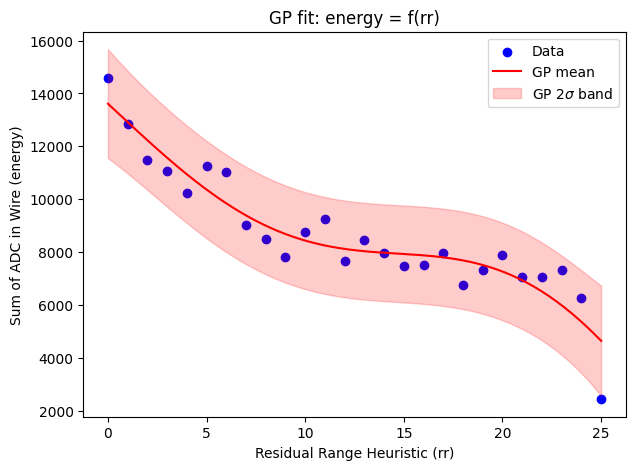

In [436]:
import matplotlib.pyplot as plt
import numpy as np

# Fit GP to a single row
row = df_deut.iloc[2]
gp = fit_gp_energy_vs_rr(row)

rr = np.asarray(row['rr']) 
energy = np.asarray(row['energy'])

# Create a smooth range for prediction
rr_pred = np.linspace(rr.min(), rr.max(), 200).reshape(-1, 1)
energy_pred, sigma = gp.predict(rr_pred, return_std=True)

plt.figure(figsize=(7, 5))
plt.scatter(rr, energy, label='Data', color='blue')
plt.plot(rr_pred, energy_pred, color='red', label='GP mean')
plt.fill_between(rr_pred.flatten(),
                 energy_pred - 2*sigma,
                 energy_pred + 2*sigma,
                 color='red', alpha=0.2, label='GP 2$\sigma$ band')
plt.xlabel('Residual Range Heuristic (rr)')
plt.ylabel('Sum of ADC in Wire (energy)')
plt.title('GP fit: energy = f(rr)')
plt.legend()
plt.show()

In [47]:
# Create a new column with the sum of the last 4 elements from each 'energy' array
def sum_last_four_energy(arr):
    if isinstance(arr, (np.ndarray, list)) and len(arr) >= 4:
        return np.sum(arr[-4:])  # Sum the last 4 elements
    elif isinstance(arr, (np.ndarray, list)) and len(arr) > 0:
        return np.sum(arr)  # If less than 4 elements, sum all available
    else:
        return np.nan  # Return NaN for empty arrays

df_deut['energy_last4_sum'] = df_deut['energy'].apply(sum_last_four_energy)
df_prot['energy_last4_sum'] = df_prot['energy'].apply(sum_last_four_energy)

# Display the first few values to verify
print("First 10 values of energy_last4_sum:")
print(df['energy_last4_sum'].head(10))
print(f"\nSummary statistics:")
print(df['energy_last4_sum'].describe())

First 10 values of energy_last4_sum:
0    66364.0
1    21075.0
2    55886.0
3    21722.0
4    15722.0
5    55746.0
6    18637.0
7    51740.0
8    21098.0
9     3844.0
Name: energy_last4_sum, dtype: float64

Summary statistics:
count     11788.000000
mean      36006.774601
std       17751.325707
min         358.000000
25%       19358.000000
50%       38265.500000
75%       52381.000000
max      172964.000000
Name: energy_last4_sum, dtype: float64


/var/folders/cm/m55y72dj6cd5lkwrfdb2bpnr0000gp/T/ipykernel_22528/3980520862.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_deut['energy_last4_sum'] = df_deut['energy'].apply(sum_last_four_energy)
/var/folders/cm/m55y72dj6cd5lkwrfdb2bpnr0000gp/T/ipykernel_22528/3980520862.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prot['energy_last4_sum'] = df_prot['energy'].apply(sum_last_four_energy)


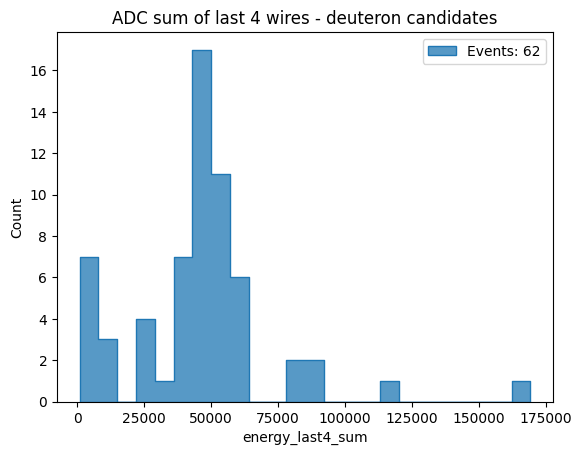

In [65]:
# Count the number of events
num_events = len(df_deut)

# Plot the histogram without the smooth line and add the number of events to the legend
sns.histplot(data=df_deut, x='energy_last4_sum', bins='auto', kde=False, element='step', stat='count', label=f'Events: {num_events}')
plt.title('ADC sum of last 4 wires - deuteron candidates')
# plt.xlim(0, 100000)
plt.legend() 
plt.show()

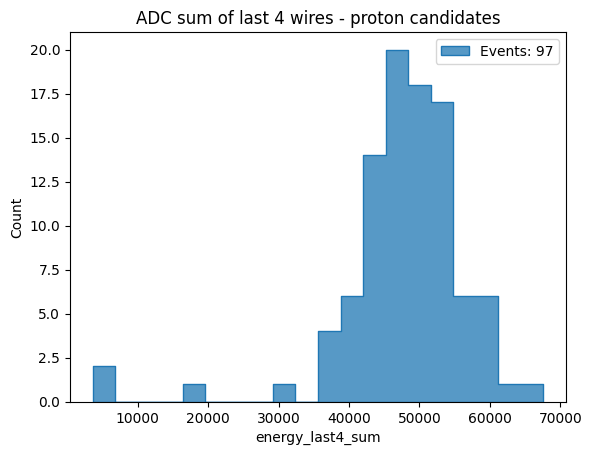

In [66]:
# Count the number of events
num_events = len(df_prot)

# Plot the histogram without the smooth line and add the number of events to the legend
sns.histplot(data=df_prot, x='energy_last4_sum', bins='auto', kde=False, element='step', stat='count', label=f'Events: {num_events}')
plt.title('ADC sum of last 4 wires - proton candidates')
# plt.xlim(0, 100000)
plt.legend() 
plt.show()

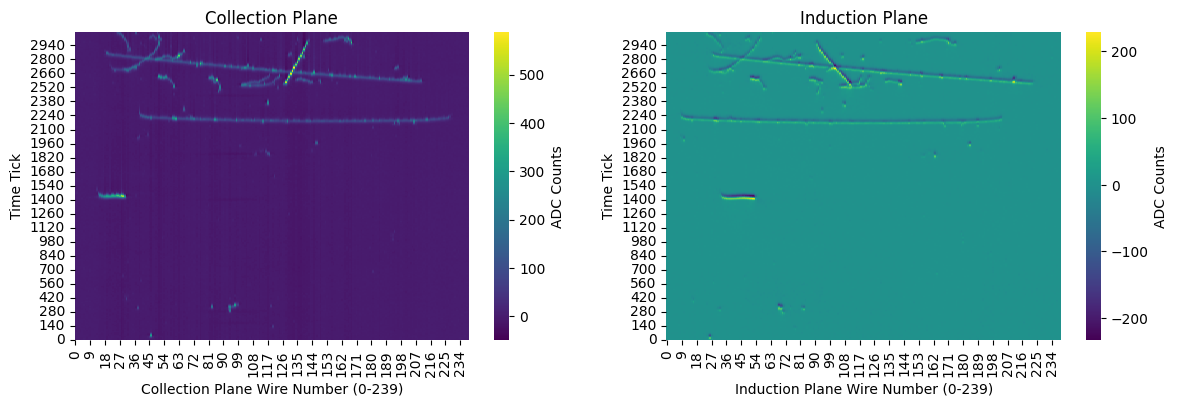

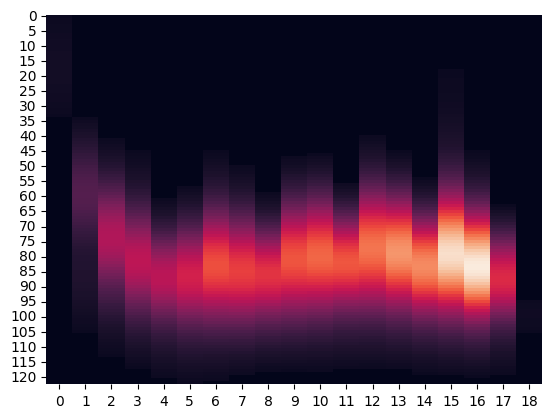

In [89]:
sample = df_deut.sample(n=1)
filepath = sample['file_path'].iloc[0]
index = sample['event_index'].iloc[0]

event = Event(filepath, index)
sns.heatmap(sample['matrix_transformed'].iloc[0], cbar=False)
plt.show()